In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import covasim as cv
from notebooks.util import data

pop_region = 4.46e6
pop_size = 450e3
pop_scale = 10

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


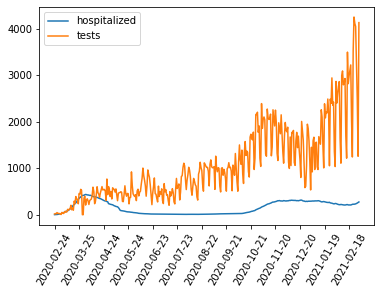

In [2]:
df = data.get_regional_data(scaling_factor=pop_region/pop_size)

plt.plot(df['cum_recoveries'], label='hospitalized')
plt.plot(df['new_tests'], label='tests')
plt.xticks(df.index[::30], rotation=60)
plt.legend()
plt.show()

In [3]:
params = dict(
    pop_type='hybrid',
    location='italy',
    start_day=df.index[0],
    end_day=df.index[-1],
    pop_size=pop_size / pop_scale,
    pop_scale=pop_scale,
    rescale=True,
    pop_infected=pop_size / 1e3,
    n_beds_hosp=pop_size * 3.18 / 1e3,
    n_beds_icu=pop_size * 12.5 / 100e3,
    verbose=0
)

In [4]:
df.to_csv('data.csv')

In [6]:
import optuna as op
from interventions import get_interventions

def run_sim(pars, label=None, return_sim=False):
    ''' Create and run a simulation '''
    
    interventions = get_interventions(pars=pars, detailed=False)
    
    sim = cv.Sim(pars=params, datafile='data.csv', interventions=interventions)
    sim.run()
    fit = sim.compute_fit()
    if return_sim:
        return sim
    else:
        return fit.mismatch

    
def run_trial(trial):
    ''' Define the objective for Optuna '''
    pars = {}
    pars["trace_prob"] = trial.suggest_uniform('trace_prob', 0.3, 0.9) # Sample from beta values within this range
    pars["trace_time"] = trial.suggest_uniform('trace_time', 1.0, 5.0) # Sample from beta values within this range
    mismatch = run_sim(pars)
    return mismatch

# Run the optimization
study = op.create_study()
study.optimize(func=run_trial, n_trials=10)
best_pars = study.best_params
print(f'\n\nOutput: {best_pars}')

[I 2021-03-03 17:08:43,538] A new study created in memory with name: no-name-14eef1c8-89af-477c-b61b-bec4a899431a
[I 2021-03-03 17:08:55,712] Trial 0 finished with value: 227677.40302387404 and parameters: {'trace_prob': 0.6033931134913301, 'trace_time': 3.3391022839576343}. Best is trial 0 with value: 227677.40302387404.
[I 2021-03-03 17:09:07,330] Trial 1 finished with value: 233345.6045942241 and parameters: {'trace_prob': 0.3129803398755237, 'trace_time': 4.629182040018943}. Best is trial 0 with value: 227677.40302387404.
[I 2021-03-03 17:09:19,004] Trial 2 finished with value: 227512.19324557125 and parameters: {'trace_prob': 0.44834656002080087, 'trace_time': 1.333469996161408}. Best is trial 2 with value: 227512.19324557125.
[I 2021-03-03 17:09:30,752] Trial 3 finished with value: 229210.45754641548 and parameters: {'trace_prob': 0.49860825107165774, 'trace_time': 1.1268048280338667}. Best is trial 2 with value: 227512.19324557125.
[I 2021-03-03 17:09:42,155] Trial 4 finished wi



Output: {'trace_prob': 0.8973745290250739, 'trace_time': 4.5076253627226315}


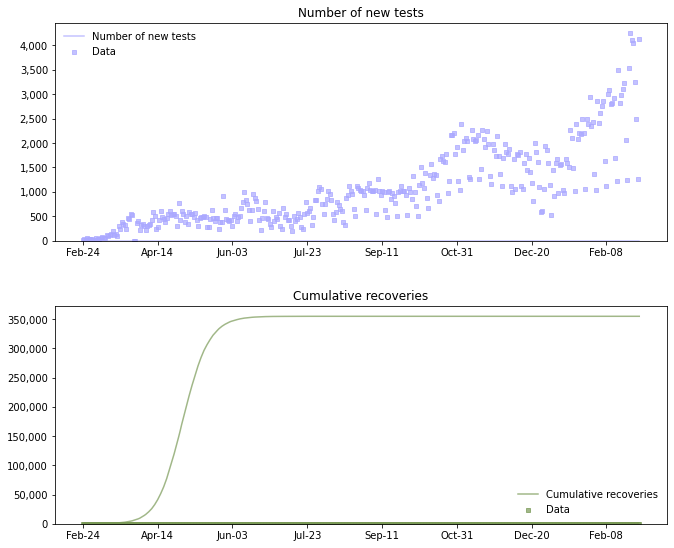

In [7]:
interventions = get_interventions(pars=best_pars, detailed=False)

sim = cv.Sim(pars=params, datafile='data.csv', label='test')
sim.run()
sim.plot(to_plot=['new_tests', 'cum_recoveries']);

In [7]:
interventions = [
    tests_intervention,
    tracing_intervention,
    #school_closed_intervention,
    #smart_working_intervention,
    #lockdown_intervention,
    #masks_intervention,
    #imported_intervention
]

sim = cv.Sim(pars=params, interventions=interventions)
msim = cv.MultiSim(sim, n_runs=30)
msim.run()

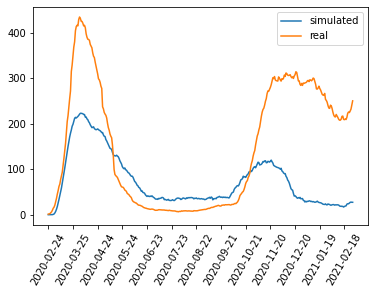

In [9]:
res = [s.results['n_severe'].values + s.results['n_critical'].values for s in msim.sims]
res = pd.Series(data=np.array(res).mean(0), index=df.index)
plt.plot(res, label='simulated')
plt.plot(df['hospitalized'], label='real')
plt.xticks(df.index[::30], rotation=60)
plt.legend()
plt.show()